In [253]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

import talib
from FinMind.data import DataLoader

api = DataLoader()
# api.login_by_token(api_token='token')
# api.login(user_id='user_id',password='password')
stock_info = api.taiwan_stock_info()

from finlab import data
import finlab
finlab.login("AiuPZ4WPXAATQGDkCCUjnGPeKpNfxa0pfe0iFPMxsNlgpZep3Qqp1KJjbwzikCtd#free")

company_info = data.get('company_basic_info')
# 將股票代碼和產業類別映射成字典
stock_to_company= dict(zip(company_info['stock_id'], company_info['公司名稱']))
stock_to_industry = dict(zip(company_info['stock_id'], company_info['產業類別']))

輸入成功!


In [255]:

def draw(scaled_data):
    # 指定要嘗試的K值範圍
    k_values = range(2, 11)
    # 通過計算不同K值下的評估指標來找到最佳K值
    inertia = []
    silhouette_scores = []
        
    # 尋找最佳K值
    for k in k_values:
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
        kmeans.fit(scaled_data)
        inertia.append(kmeans.inertia_)
        silhouette_scores.append(metrics.silhouette_score(scaled_data, kmeans.labels_))

    # 繪製肘部法則和輪廓係數的圖形
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(2, 11), inertia, marker='o')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')

    plt.subplot(1, 2, 2)
    plt.plot(range(2, 11), silhouette_scores, marker='o')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score')

    plt.tight_layout()
    plt.show()
    print("Inertia: ", inertia)
    print("Silhouette Score: ", silhouette_scores)



def choose_k_value(k_value, scaled_data, data, draw):
    print("k = ", k_value)
    # 使用最佳K值創建KMeans模型
    kmeans = KMeans(n_clusters=k_value, n_init=10, random_state=42)
    kmeans.fit(scaled_data)

    # 將分類結果添加到原始數據中
    data['Cluster'] = kmeans.labels_

    # 視覺化聚類結果
    if draw ==1:
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(scaled_data)
        plt.figure(figsize=(10, 6))
        for i in range(k_value):
            plt.scatter(pca_result[kmeans.labels_ == i, 0], pca_result[kmeans.labels_ == i, 1], label=f'Cluster {i}')
        plt.title('KMeans Clustering')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.legend()
        plt.show()
    
    # 根據股票代碼添加產業類別到 merged_data 中
    data_with_name = data.copy()
    data_with_name['公司名稱'] = data.index.map(stock_to_company)
    data_with_name['產業類別'] = data.index.map(stock_to_industry)

    # 將 MultiIndex 轉換回單一索引 (只針對 'Cluster' 列進行轉換)
    data_with_name.columns = data_with_name.columns.map(lambda x: x[0] if x[0] != 'Cluster' else x[0])

    # 顯示每個集群中的股票
    for cluster in range(k_value):
        n_stocks = data_with_name[data_with_name['Cluster'] == cluster].shape[0]
        print(f'Cluster {cluster}: {n_stocks}檔')
        # print(data_with_name[data_with_name['Cluster'] == cluster].index)
        print(data_with_name[data_with_name['Cluster'] == cluster][['公司名稱', '產業類別']])
        print()


    # 內部評估指標
    silhouette_score = metrics.silhouette_score(scaled_data, kmeans.labels_)
    print("Silhouette Score:", silhouette_score)
    inertia_score = kmeans.inertia_
    print("Inertia: ", inertia_score)



### Kmeans基本面
全部資料

In [256]:

# 讀取數據
financial_data = pd.read_csv('financial_data_cleaned.csv', index_col=[0, 1])
# 將數據進行轉置
financial_data = financial_data.transpose()


# 將日期轉換為 Pandas 的 datetime 格式
financial_data.columns = pd.MultiIndex.from_tuples([(level, pd.to_datetime(date)) for level, date in financial_data.columns])

# 根據日期排序
financial_data = financial_data.sort_index(axis=1)


In [386]:
financial_data

每股盈餘                                                         \
     2013-03-31 2013-05-15 2013-08-14 2013-11-14 2014-03-31 2014-05-15   
1102       0.67       0.40       0.83       0.34       0.69       0.47   
1103       1.60       0.13      -0.05       0.29      -0.20      -0.06   
1104       0.59       0.30       0.56       0.39       0.56       0.40   
1108       0.02       0.17       0.11       0.14       0.18       0.18   
1109       0.35       0.09       0.16       0.05       0.12       0.20   
...         ...        ...        ...        ...        ...        ...   
9951       2.12       1.38       1.69       1.85       2.45       2.39   
9955      -0.63       0.06      -0.89       0.84       0.18       0.12   
9958      -0.06       0.53       0.41       0.37       0.05       0.22   
9960       0.32       0.15       0.41       0.29       0.20       0.00   
9962       0.10       0.51      -0.08       0.24      -0.62       0.15   

                                                  ...         資產總額  \
     2014-08-14 2014-11-14 2015-03-31 2015-05-15  ...   2018-08-14   
1102       1.21       0.64       0.14       0.47  ...  258644541.0   
1103       0.06       0.24       0.96      -0.29  ...   31528629.0   
1104       0.73       0.58       0.76       0.43  ...   22514024.0   
1108       0.37       0.20       0.15       0.39  ...    7142323.0   
1109       0.26       0.08       0.13       0.02  ...    9016549.0   
...         ...        ...        ...        ...  ...          ...   
9951       1.81       1.15       2.47       1.34  ...    5653087.0   
9955       0.01       0.05      -0.74       0.08  ...    3253357.0   
9958       0.13      -0.05       0.47       0.02  ...    6857036.0   
9960       0.22       0.20       0.18       0.09  ...     672292.0   
9962       0.25       0.42      -0.12      -0.40  ...    1389869.0   

                                                                       \
       2018-11-14   2019-03-31   2019-05-15   2019-08-14   2019-11-14   
1102  277109908.0  297278512.0  286909551.0  295740045.0  290392669.0   
1103   32567456.0   38720634.0   34436093.0   36544503.0   35998597.0   
1104   22323255.0   23401933.0   23115808.0   23547482.0   22981689.0   
1108    7232026.0    7328877.0    7507236.0    7435407.0    7397483.0   
1109    8993316.0   11191294.0    9915243.0   10432186.0   10398129.0   
...           ...          ...          ...          ...          ...   
9951    5609133.0    5427063.0    5584263.0    5527695.0    5261503.0   
9955    3279425.0    2926478.0    3058297.0    2985939.0    2938992.0   
9958    9280166.0   11241437.0   10325622.0   10575609.0    9992378.0   
9960     655813.0     799114.0     769815.0     758493.0     774820.0   
9962    1343821.0    1297488.0    1273111.0    1201883.0    1197050.0   

                                            Cluster  
       2020-05-15   2020-08-14   2020-11-14     NaT  
1102  303438912.0  296268103.0  302070074.0       0  
1103   37064695.0   37805518.0   37697289.0       0  
1104   22792156.0   23263325.0   23131814.0       0  
1108    7503206.0    7562919.0    7873384.0       0  
1109   10553781.0   10612076.0   10812390.0       0  
...           ...          ...          ...     ...  
9951    4962081.0    4853230.0    5079199.0       0  
9955    3008848.0    2861932.0    2963910.0       0  
9958   12257481.0   14023928.0   16279121.0       0  
9960     787641.0     784757.0     786892.0       0  
9962    1272137.0    1223675.0    1049237.0       0  

[1290 rows x 280 columns]

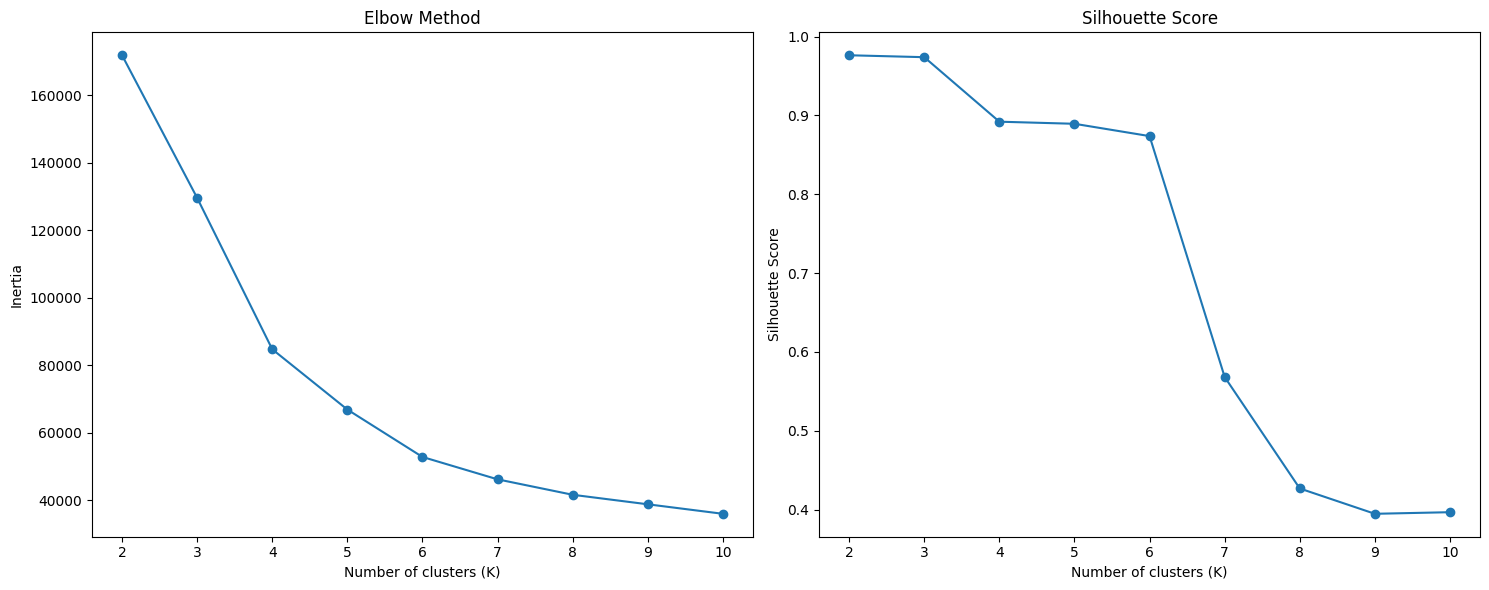

Inertia:  [171879.26862279643, 129599.28582470989, 84740.75437009854, 66874.632415676, 52831.75675967046, 46197.40020094982, 41621.857685750285, 38800.84829005839, 35984.42053114268]
Silhouette Score:  [0.9763216199678619, 0.9738785987670759, 0.8920567593490104, 0.8893991307738542, 0.8737705078879834, 0.5681946704855598, 0.4268165600330999, 0.3946934270591349, 0.39671990667500395]


In [257]:
# 標準化數據
scaler = StandardScaler()
scaled_financial_data = scaler.fit_transform(financial_data)
draw(scaled_financial_data)

k =  4


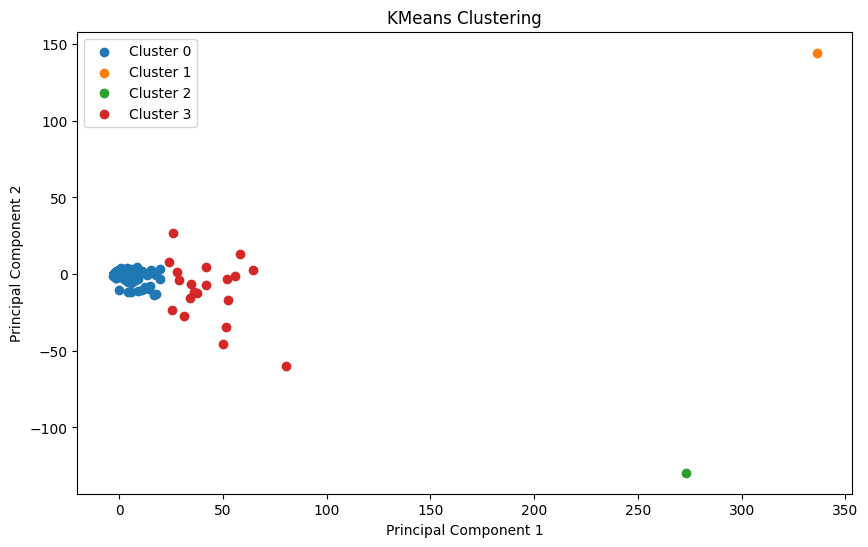

Cluster 0: 1268檔
               公司名稱  產業類別
1102     亞洲水泥股份有限公司  水泥工業
1103     嘉新水泥股份有限公司  水泥工業
1104     環球水泥股份有限公司  水泥工業
1108     幸福水泥股份有限公司  水泥工業
1109     信大水泥股份有限公司  水泥工業
...             ...   ...
9951     皇田工業股份有限公司  電機機械
9955   佳龍科技工程股份有限公司    其他
9958   世紀鋼鐵結構股份有限公司  鋼鐵工業
9960  邁達康網路事業股份有限公司  貿易百貨
9962     有益鋼鐵股份有限公司  鋼鐵工業

[1268 rows x 2 columns]

Cluster 1: 1檔
                公司名稱  產業類別
2330  台灣積體電路製造股份有限公司  半導體業

Cluster 2: 1檔
              公司名稱   產業類別
2317  鴻海精密工業股份有限公司  其他電子業

Cluster 3: 20檔
                公司名稱      產業類別
1216      統一企業股份有限公司      食品工業
1303    南亞塑膠工業股份有限公司      塑膠工業
1326    台灣化學纖維股份有限公司      塑膠工業
1402     遠東新世紀股份有限公司      紡織纖維
2002      中國鋼鐵股份有限公司      鋼鐵工業
2303      聯華電子股份有限公司      半導體業
2308    台達電子工業股份有限公司    電子零組件業
2324    仁寶電腦工業股份有限公司  電腦及週邊設備業
2357      華碩電腦股份有限公司  電腦及週邊設備業
2382      廣達電腦股份有限公司  電腦及週邊設備業
2409      友達光電股份有限公司       光電業
2412      中華電信股份有限公司     通信網路業
2454      聯發科技股份有限公司      半導體業
2474      可成科技股份有限公司     其他電子業
2823    中國人壽保險股份有限公司     金融保險

In [258]:
choose_k_value(4, scaled_financial_data, financial_data, 1)

部分基本面資料
- 財報截止日:
1. 'Q1': '3-31'
2. 'Q2': '5-15' 
3. 'Q3': '8-14' 
4. 'Q4': '11-14'

- supervised training index:
1. 2013-01-03 - 2014-02-12
2. 2013-01-03 - 2015-03-11
3. 2013-01-03 - 2016-03-29 
4. 2013-01-03 - 2017-04-20 
5. 2013-01-03 - 2018-05-10 

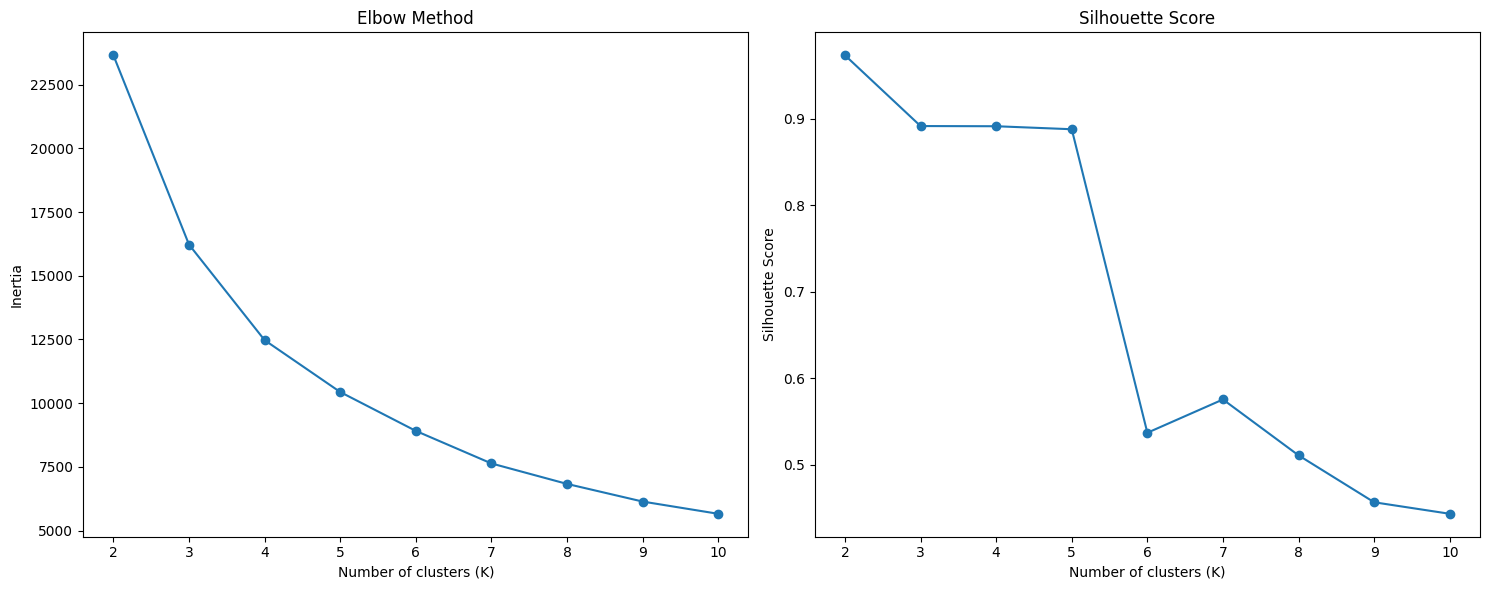

Inertia:  [23653.26814272891, 16222.737514746039, 12472.208479350315, 10436.340576042054, 8910.341268619053, 7632.648640719919, 6829.361762624162, 6136.754792653228, 5656.248900698127]
Silhouette Score:  [0.9732280778976948, 0.8913697225392911, 0.8911548988487151, 0.8876835779505062, 0.5367198074782817, 0.5752105646078733, 0.5105959463832425, 0.4563354145634667, 0.44301443745239416]


In [362]:
# 使用IndexSlice選擇日期範圍
idx = pd.IndexSlice
start_date = pd.Timestamp('2013-03-31')
end_date = pd.Timestamp('2013-11-14')
selected_financial_data = financial_data.loc[:, idx[:, start_date:end_date]]
# 標準化數據
scaler = StandardScaler()
scaled_selected_financial_data = scaler.fit_transform(selected_financial_data)
draw(scaled_selected_financial_data)


k =  5


C:\Users\user\AppData\Local\Temp\ipykernel_10316\3657756203.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cluster'] = kmeans.labels_


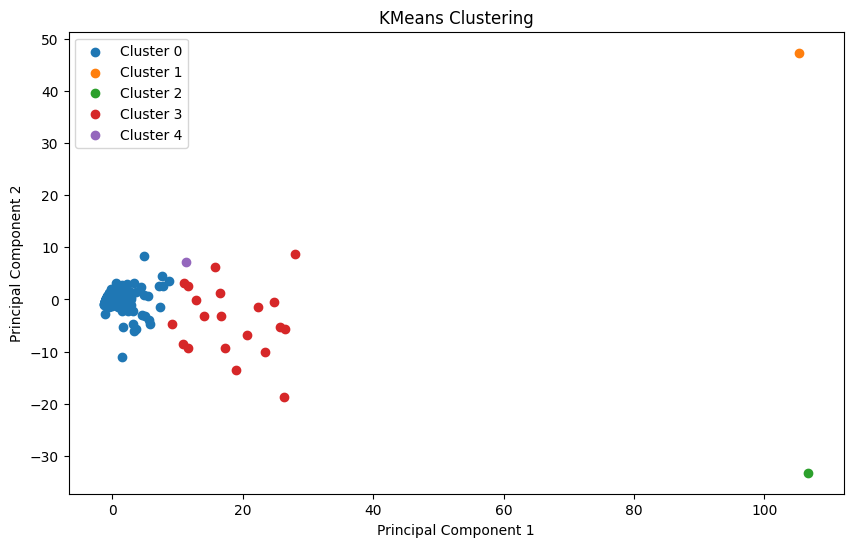

Cluster 0: 1267檔
               公司名稱  產業類別
1102     亞洲水泥股份有限公司  水泥工業
1103     嘉新水泥股份有限公司  水泥工業
1104     環球水泥股份有限公司  水泥工業
1108     幸福水泥股份有限公司  水泥工業
1109     信大水泥股份有限公司  水泥工業
...             ...   ...
9951     皇田工業股份有限公司  電機機械
9955   佳龍科技工程股份有限公司    其他
9958   世紀鋼鐵結構股份有限公司  鋼鐵工業
9960  邁達康網路事業股份有限公司  貿易百貨
9962     有益鋼鐵股份有限公司  鋼鐵工業

[1267 rows x 2 columns]

Cluster 1: 1檔
                公司名稱  產業類別
2330  台灣積體電路製造股份有限公司  半導體業

Cluster 2: 1檔
              公司名稱   產業類別
2317  鴻海精密工業股份有限公司  其他電子業

Cluster 3: 20檔
                公司名稱      產業類別
1216      統一企業股份有限公司      食品工業
1303    南亞塑膠工業股份有限公司      塑膠工業
1326    台灣化學纖維股份有限公司      塑膠工業
1402     遠東新世紀股份有限公司      紡織纖維
2002      中國鋼鐵股份有限公司      鋼鐵工業
2105    正新橡膠工業股份有限公司      橡膠工業
2303      聯華電子股份有限公司      半導體業
2308    台達電子工業股份有限公司    電子零組件業
2324    仁寶電腦工業股份有限公司  電腦及週邊設備業
2356       英業達股份有限公司  電腦及週邊設備業
2357      華碩電腦股份有限公司  電腦及週邊設備業
2382      廣達電腦股份有限公司  電腦及週邊設備業
2409      友達光電股份有限公司       光電業
2412      中華電信股份有限公司     通信網路業
2454      聯發科技股份有限公司      半導體

In [364]:
choose_k_value(5, scaled_selected_financial_data, selected_financial_data, 1)

Kemans技術面
- 全部資料

In [313]:


# 讀取數據
technical_data = pd.read_csv('common_technical_data.csv', index_col=[0, 1])

# # 移除缺失值
# technical_data.dropna(inplace=True)

# 將數據進行轉置
technical_data = technical_data.transpose()

# 將日期轉換為 Pandas 的 datetime 格式
technical_data.columns = pd.MultiIndex.from_tuples([(level, pd.to_datetime(date)) for level, date in technical_data.columns])

# 根據日期排序
technical_data = technical_data.sort_index(axis=1)

# 用插值法填補缺失值
filled_technical_data = technical_data.interpolate(method='linear', axis=1)
# 創建SimpleImputer物件，設置strategy為'ffill'以前向填補缺失值
imputer = SimpleImputer(strategy='mean')
# 使用imputer對技術面資料進行填補
filled_technical_data = pd.DataFrame(imputer.fit_transform(filled_technical_data), index=filled_technical_data.index, columns=filled_technical_data.columns)

# 標準化數據
scaler = StandardScaler()
scaled_filled_technical_data = scaler.fit_transform(filled_technical_data)
draw(scaled_filled_technical_data)


k =  4


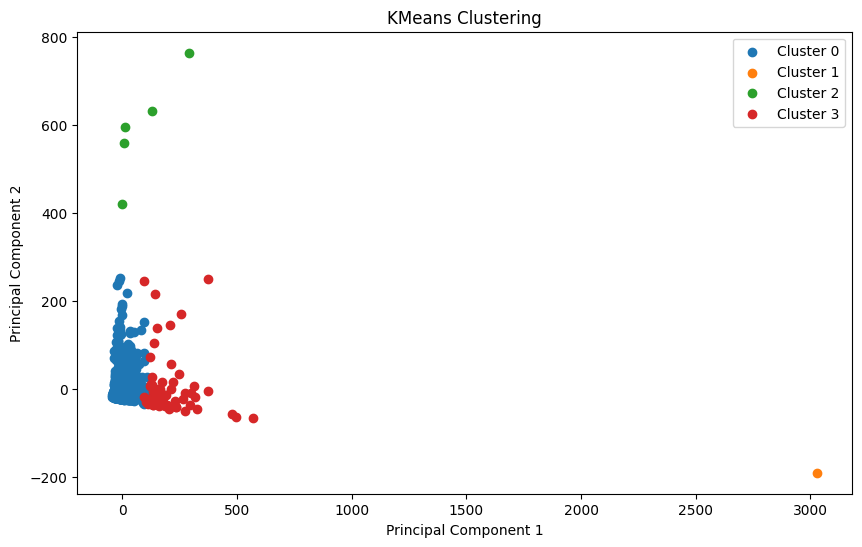

Cluster 0: 1226檔
               公司名稱  產業類別
1102     亞洲水泥股份有限公司  水泥工業
1103     嘉新水泥股份有限公司  水泥工業
1104     環球水泥股份有限公司  水泥工業
1108     幸福水泥股份有限公司  水泥工業
1109     信大水泥股份有限公司  水泥工業
...             ...   ...
9951     皇田工業股份有限公司  電機機械
9955   佳龍科技工程股份有限公司    其他
9958   世紀鋼鐵結構股份有限公司  鋼鐵工業
9960  邁達康網路事業股份有限公司  貿易百貨
9962     有益鋼鐵股份有限公司  鋼鐵工業

[1226 rows x 2 columns]

Cluster 1: 1檔
            公司名稱 產業類別
3008  大立光電股份有限公司  光電業

Cluster 2: 5檔
                公司名稱   產業類別
2303      聯華電子股份有限公司   半導體業
2317    鴻海精密工業股份有限公司  其他電子業
2330  台灣積體電路製造股份有限公司   半導體業
2409      友達光電股份有限公司    光電業
3481      群創光電股份有限公司    光電業

Cluster 3: 58檔
                              公司名稱      產業類別
1256                    鮮活控股股份有限公司      食品工業
1476                    儒鴻企業股份有限公司      紡織纖維
1477                    聚陽實業股份有限公司      紡織纖維
1558                    伸興工業股份有限公司      電機機械
1565                    精華光學股份有限公司     生技醫療業
1590                       亞德客國際集團      電機機械
1707                   葡萄王生技股份有限公司     生技醫療業
1723                  中鋼碳素化學

In [322]:
choose_k_value(4, scaled_filled_technical_data, filled_technical_data, 1)

部分技術面資料
- 財報截止日:
1. 'Q1': '3-31'
2. 'Q2': '5-15' 
3. 'Q3': '8-14' 
4. 'Q4': '11-14'

- supervised training index:
1. 2013-01-03 - 2014-02-12
2. 2013-01-03 - 2015-03-11
3. 2013-01-03 - 2016-03-29 
4. 2013-01-03 - 2017-04-20 
5. 2013-01-03 - 2018-05-10 

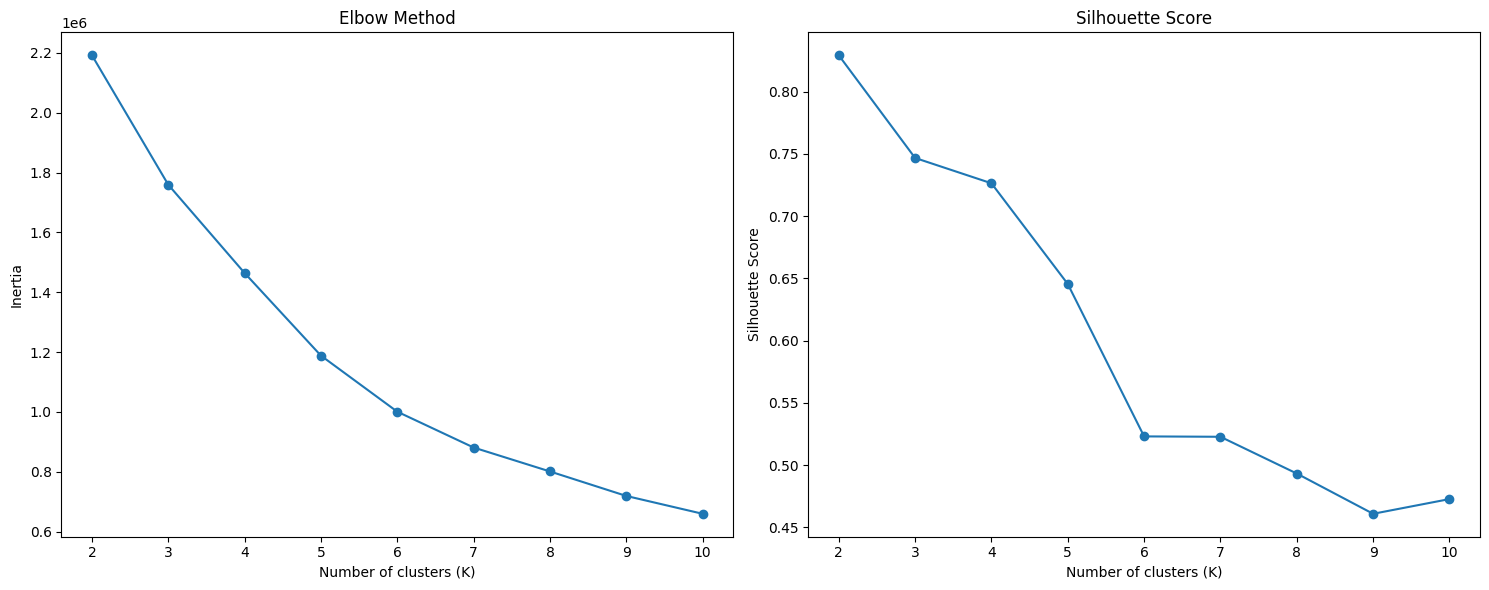

Inertia:  [2192000.7685292503, 1759349.6459953636, 1464324.756334187, 1188277.0998007096, 1000985.8228740528, 881258.3254769248, 801267.7302826765, 719447.4765838363, 659833.9643632171]
Silhouette Score:  [0.8292890172826655, 0.7467966123104716, 0.7264611455726975, 0.6455526072349382, 0.5231299171040428, 0.5228277050659854, 0.49330091409532534, 0.46096158735660303, 0.4727836612372943]


In [376]:
# 使用IndexSlice選擇日期範圍
idx = pd.IndexSlice
start_date = pd.Timestamp('2013-01-03')
end_date = pd.Timestamp('2014-02-12')
selected_filled_technical_data = filled_technical_data.loc[:, idx[:, start_date:end_date]]
# 標準化數據
scaler = StandardScaler()
scaled_selected_filled_technical_data = scaler.fit_transform(selected_filled_technical_data)
draw(scaled_selected_filled_technical_data)

k =  4


C:\Users\user\AppData\Local\Temp\ipykernel_10316\3657756203.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cluster'] = kmeans.labels_


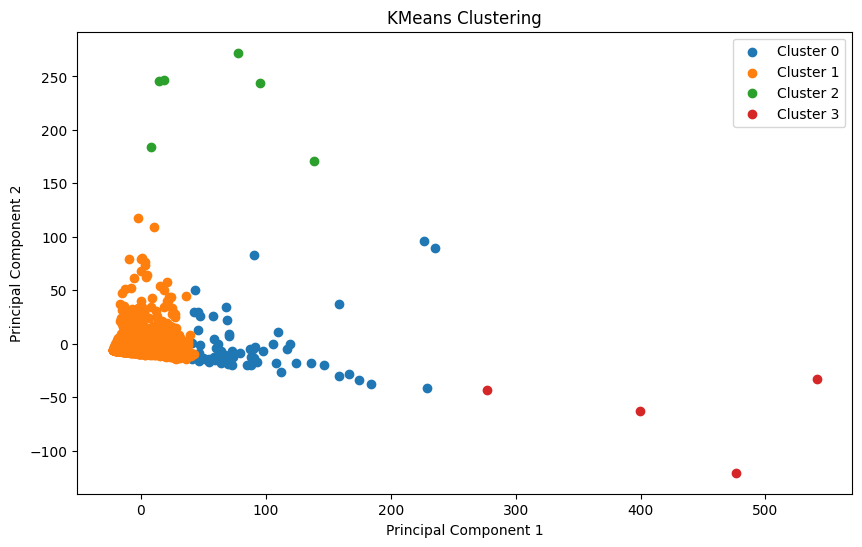

Cluster 0: 63檔
              公司名稱   產業類別
1256    鮮活控股股份有限公司   食品工業
1476    儒鴻企業股份有限公司   紡織纖維
1477    聚陽實業股份有限公司   紡織纖維
1558    伸興工業股份有限公司   電機機械
1580    新麥企業股份有限公司   電機機械
...            ...    ...
8422     可寧衛股份有限公司     其他
8436    大江生醫股份有限公司  生技醫療業
8446  華研國際音樂股份有限公司  文化創意業
9914   美利達工業股份有限公司     其他
9921  巨大機械工業股份有限公司     其他

[63 rows x 2 columns]

Cluster 1: 1217檔
               公司名稱  產業類別
1102     亞洲水泥股份有限公司  水泥工業
1103     嘉新水泥股份有限公司  水泥工業
1104     環球水泥股份有限公司  水泥工業
1108     幸福水泥股份有限公司  水泥工業
1109     信大水泥股份有限公司  水泥工業
...             ...   ...
9951     皇田工業股份有限公司  電機機械
9955   佳龍科技工程股份有限公司    其他
9958   世紀鋼鐵結構股份有限公司  鋼鐵工業
9960  邁達康網路事業股份有限公司  貿易百貨
9962     有益鋼鐵股份有限公司  鋼鐵工業

[1217 rows x 2 columns]

Cluster 2: 6檔
                公司名稱   產業類別
2303      聯華電子股份有限公司   半導體業
2317    鴻海精密工業股份有限公司  其他電子業
2330  台灣積體電路製造股份有限公司   半導體業
2409      友達光電股份有限公司    光電業
2498    宏達國際電子股份有限公司  通信網路業
3481      群創光電股份有限公司    光電業

Cluster 3: 4檔
                              公司名稱   產業類別
1565                    精華光

In [377]:
choose_k_value(4, scaled_selected_filled_technical_data, selected_filled_technical_data, 1)

Kmeans 合併資料


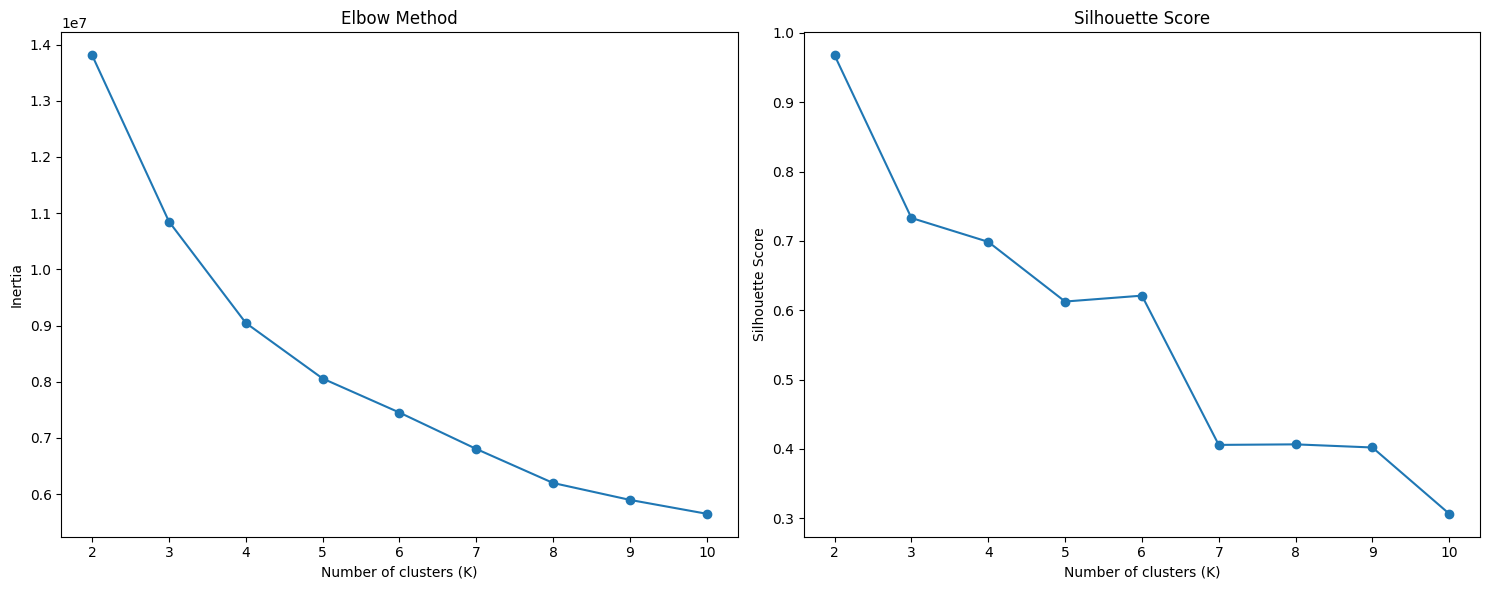

Inertia:  [13808621.128918162, 10849886.408009568, 9046153.629661042, 8057177.343489178, 7451601.308399719, 6804126.414940164, 6198539.418779022, 5897850.192825921, 5650802.760417751]
Silhouette Score:  [0.9677714591913601, 0.7330805107551712, 0.6986281675952237, 0.6125303079414216, 0.6210326199242845, 0.4057520136207415, 0.4065235416343283, 0.40201194646889055, 0.30636755784826236]


In [379]:
# 讀取數據
merged_data = pd.read_csv('merged_data.csv', index_col=[0, 1])

# 將數據進行轉置
merged_data = merged_data.transpose()

# 將日期轉換為 Pandas 的 datetime 格式
merged_data.columns = pd.MultiIndex.from_tuples([(level, pd.to_datetime(date)) for level, date in merged_data.columns])

# 根據日期排序
merged_data = merged_data.sort_index(axis=1)

# 用插值法填補缺失值
filled_merged_data = merged_data.interpolate(method='linear', axis=1)
# 創建SimpleImputer物件，設置strategy為'ffill'以前向填補缺失值
imputer = SimpleImputer(strategy='mean')
# 使用imputer對技術面資料進行填補
filled_merged_data = pd.DataFrame(imputer.fit_transform(filled_merged_data), index=filled_merged_data.index, columns=filled_merged_data.columns)

# 標準化數據
scaler = StandardScaler()
scaled_filled_merged_data = scaler.fit_transform(filled_merged_data)
draw(scaled_filled_merged_data)

In [380]:
choose_k_value(6, scaled_filled_merged_data, filled_merged_data, 0)

k =  6
Cluster 0: 1146檔
               公司名稱  產業類別
1103     嘉新水泥股份有限公司  水泥工業
1104     環球水泥股份有限公司  水泥工業
1108     幸福水泥股份有限公司  水泥工業
1109     信大水泥股份有限公司  水泥工業
1110     東南水泥股份有限公司  水泥工業
...             ...   ...
9951     皇田工業股份有限公司  電機機械
9955   佳龍科技工程股份有限公司    其他
9958   世紀鋼鐵結構股份有限公司  鋼鐵工業
9960  邁達康網路事業股份有限公司  貿易百貨
9962     有益鋼鐵股份有限公司  鋼鐵工業

[1146 rows x 2 columns]

Cluster 1: 1檔
            公司名稱 產業類別
3008  大立光電股份有限公司  光電業

Cluster 2: 3檔
            公司名稱  產業類別
2303  聯華電子股份有限公司  半導體業
2409  友達光電股份有限公司   光電業
3481  群創光電股份有限公司   光電業

Cluster 3: 52檔
                              公司名稱      產業類別
1256                    鮮活控股股份有限公司      食品工業
1476                    儒鴻企業股份有限公司      紡織纖維
1477                    聚陽實業股份有限公司      紡織纖維
1558                    伸興工業股份有限公司      電機機械
1565                    精華光學股份有限公司     生技醫療業
1590                       亞德客國際集團      電機機械
1707                   葡萄王生技股份有限公司     生技醫療業
2049                    上銀科技股份有限公司      電機機械
2059                    川湖科技股份有限公司    電子零組件業
2227   

部分合併資料
- 財報截止日:
1. 'Q1': '3-31'
2. 'Q2': '5-15' 
3. 'Q3': '8-14' 
4. 'Q4': '11-14'

- supervised training index:
1. 2013-01-03 - 2014-02-12
2. 2013-01-03 - 2015-03-11
3. 2013-01-03 - 2016-03-29 
4. 2013-01-03 - 2017-04-20 
5. 2013-01-03 - 2018-05-10 

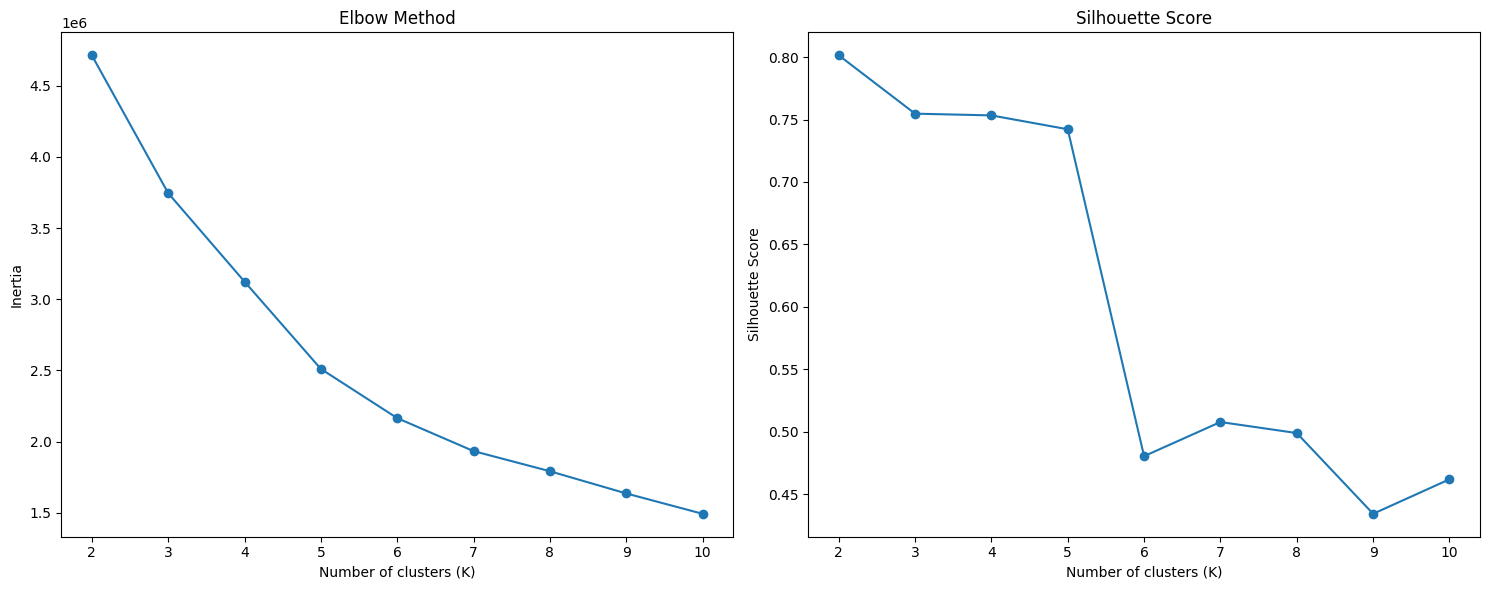

Inertia:  [4714476.009389633, 3745773.0828984203, 3123756.5303065344, 2510276.291860853, 2164486.478023863, 1932655.9674134057, 1791118.5851236093, 1635010.1329920504, 1492000.5374965752]
Silhouette Score:  [0.8014438273497007, 0.7546982186992451, 0.7533088209605163, 0.7422140862389432, 0.48053900589496773, 0.5078779511377048, 0.49904788539479816, 0.43442164402171973, 0.462030542741159]


In [384]:
# 使用IndexSlice選擇日期範圍
idx = pd.IndexSlice
start_date = pd.Timestamp('2013-01-03')
end_date = pd.Timestamp('2015-03-11')
selected_filled_merged_data = filled_merged_data.loc[:, idx[:, start_date:end_date]]
# 標準化數據
scaler = StandardScaler()
scaled_selected_filled_merged_data = scaler.fit_transform(selected_filled_merged_data)
draw(scaled_selected_filled_merged_data)

k =  5


C:\Users\user\AppData\Local\Temp\ipykernel_10316\3657756203.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cluster'] = kmeans.labels_


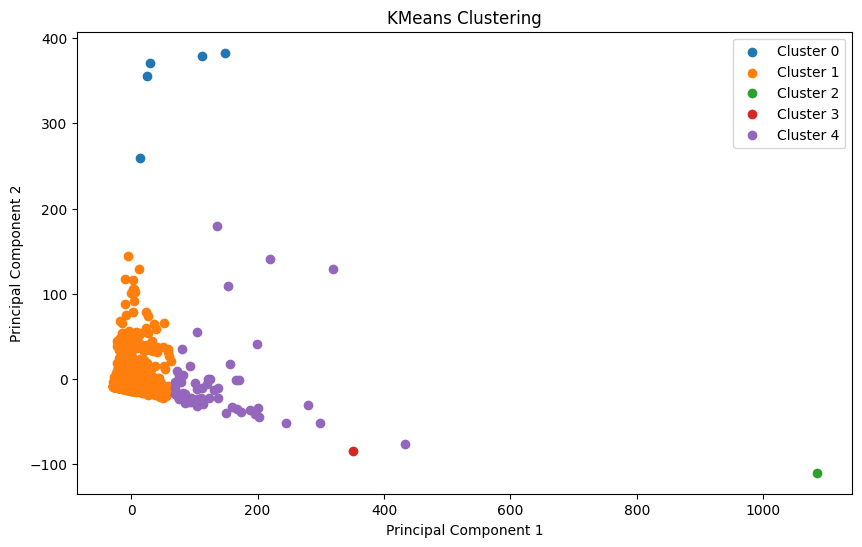

Cluster 0: 5檔
                公司名稱   產業類別
2303      聯華電子股份有限公司   半導體業
2317    鴻海精密工業股份有限公司  其他電子業
2330  台灣積體電路製造股份有限公司   半導體業
2409      友達光電股份有限公司    光電業
3481      群創光電股份有限公司    光電業

Cluster 1: 1227檔
               公司名稱  產業類別
1102     亞洲水泥股份有限公司  水泥工業
1103     嘉新水泥股份有限公司  水泥工業
1104     環球水泥股份有限公司  水泥工業
1108     幸福水泥股份有限公司  水泥工業
1109     信大水泥股份有限公司  水泥工業
...             ...   ...
9951     皇田工業股份有限公司  電機機械
9955   佳龍科技工程股份有限公司    其他
9958   世紀鋼鐵結構股份有限公司  鋼鐵工業
9960  邁達康網路事業股份有限公司  貿易百貨
9962     有益鋼鐵股份有限公司  鋼鐵工業

[1227 rows x 2 columns]

Cluster 2: 1檔
            公司名稱 產業類別
3008  大立光電股份有限公司  光電業

Cluster 3: 1檔
            公司名稱   產業類別
6409  旭隼科技股份有限公司  其他電子業

Cluster 4: 56檔
                              公司名稱      產業類別
1256                    鮮活控股股份有限公司      食品工業
1476                    儒鴻企業股份有限公司      紡織纖維
1477                    聚陽實業股份有限公司      紡織纖維
1558                    伸興工業股份有限公司      電機機械
1565                    精華光學股份有限公司     生技醫療業
1580                    新麥企業股份有限公司      電機機械
1590      

In [385]:
choose_k_value(5, scaled_selected_filled_merged_data, selected_filled_merged_data, 1)